In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=2f9f26c961210d5e3b911ca15d7198dd1b2df8229c11755432c196bc0fa961be
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


1. MEMBUAT SPARK SESSION

In [ ]:
import pyspark
import pandas as pd

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Big Data UAS").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()


2. MEMBUAT DATAFRAME

In [ ]:
df_pandas = pd.read_excel('/content/drive/MyDrive/Big Data UAS/Online Retail.xlsx')

df_spark = spark.createDataFrame(df_pandas)


In [ ]:
df_spark.show(5,0)



+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
+---------+-----

a. InvoiceNo: Pengidentifikasi unik dari setiap faktur pelanggan.

b. StockCode: Pengidentifikasi unik dari setiap item dalam stok.

c. Deskripsi: Barang yang dibeli oleh pelanggan.

d. Kuantitas: Jumlah setiap item yang dibeli oleh pelanggan dalam satu faktur.

e. Tanggal Faktur: Tanggal pembelian.

f. UnitPrice: Harga satu unit dari setiap item.

g. CustomerID: Pengidentifikasi unik yang ditetapkan untuk setiap pengguna.

h. Negara: Negara tempat pembelian dilakukan

**3. Exploratory Data Analysis**

In [ ]:
# jumlah row dataframe

df_spark.count()

541909

In [ ]:
# jumlah pelanggan yang unique

df_spark.select('CustomerID').distinct().count()

4373

In [ ]:
#negara dengan jumlah pembelian terbanyak

from pyspark.sql.functions import *
from pyspark.sql.types import *

df_spark.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3951|
|        Germany|           95|
|         France|           88|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           22|
|       Portugal|           20|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|    Unspecified|            5|
+---------------+-------------+
only showing top 20 rows



In [ ]:
# data penjualan terakhir

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df_spark = df_spark.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df_spark.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [ ]:
# data penjualan pertama

df_spark.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+



**4. Data Pre-processing**

In [ ]:
df_spark.show(5,0)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|2010-12-01 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|2010-12-01 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|2010-12-01 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|2010-12-01 08:26:00|

In [ ]:
# i) Assign a recency score to each customer

df_spark = df_spark.withColumn("from_date", lit("12/1/10 08:26"))
df_spark = df_spark.withColumn('from_date', to_timestamp("from_date", 'dd/MM/yy HH:mm'))

df2 = df_spark.withColumn('from_date', to_timestamp(col('from_date'))) \
        .withColumn('recency', col("date").cast("long") - col('from_date').cast("long"))


In [ ]:
# ii) Pilih pembelian terbaru

df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [ ]:
df2.show(5,0)

+--------+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|recency |InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |date               |from_date          |
+--------+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+-------------------+
|39934500|550619   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|12      |2011-04-19 13:21:00|2.95     |15717.0   |United Kingdom|2011-04-19 13:21:00|2010-01-12 08:26:00|
|39934500|550619   |84970L   |SINGLE HEART ZINC T-LIGHT HOLDER  |12      |2011-04-19 13:21:00|0.95     |15717.0   |United Kingdom|2011-04-19 13:21:00|2010-01-12 08:26:00|
|39934500|550619   |84970S   |HANGING HEART ZINC T-LIGHT HOLDER |12      |2011-04-19 13:21:00|0.85     |15717.0   |United Kingdom|2011-04-19 13:2

In [ ]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [ ]:
# Frequency

df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|12493.0   |11       |
|13973.0   |11       |
|13533.0   |33       |
|18114.0   |28       |
|14285.0   |5        |
+----------+---------+
only showing top 5 rows



In [ ]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')
df3.printSchema()

root
 |-- CustomerID: double (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [ ]:
df3.show()

+----------+--------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|CustomerID| recency|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|
+----------+--------+---------+---------+--------------------+--------+-------------------+---------+--------------+-------------------+-------------------+---------+
|   12493.0|45885060|   558124|    23084|  RABBIT NIGHT LIGHT|      12|2011-06-27 10:17:00|     2.08|        France|2011-06-27 10:17:00|2010-01-12 08:26:00|       11|
|   12493.0|45885060|   558124|    23199|    JUMBO BAG APPLES|      10|2011-06-27 10:17:00|     2.08|        France|2011-06-27 10:17:00|2010-01-12 08:26:00|       11|
|   12493.0|45885060|   558124|    22385|JUMBO BAG SPACEBO...|      10|2011-06-27 10:17:00|     2.08|        France|2011-06-27 10:17:00|2010-01-12 08:26:00|       11

Monetary Value


In [ ]:
# i) Find the total amount spent in each purchase:

m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [ ]:
# ii) Find the total amount spent by each customer:

m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [ ]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()


In [ ]:
finaldf.show()

+--------+---------+-------------------+----------+
| recency|frequency|     monetary_value|CustomerID|
+--------+---------+-------------------+----------+
|58160520|       93| 378.17999999999995|   16916.0|
|56344200|       26| 166.67000000000004|   16208.0|
|55061040|       36|             557.74|   14640.0|
|53415900|       31|  828.3899999999999|   17311.0|
|59453040|       16| 498.44000000000005|   16701.0|
|58687140|        1|              510.0|   17500.0|
|30958200|      157| 1048.8500000000006|   15464.0|
|57483960|       57| 424.57000000000016|   16284.0|
|43222920|       63|            1197.54|   14227.0|
|54101400|       11|              97.35|   17376.0|
|36901380|       22|             343.62|   15047.0|
|45545340|        7|             137.45|   17709.0|
|41943660|        1|-4.9799999999999995|   13952.0|
|42790440|        6| 114.60000000000001|   15724.0|
|33377700|       17| 334.40000000000003|   12350.0|
|46500780|        9| 289.96000000000004|   17464.0|
|58351740|  

Standardization


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [ ]:
data_scale_output.select('standardized').show(2,truncate=False)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[6.66024531754086,0.32221215932308994,0.08466292661893093] |
|[6.452249639800087,0.09008081873548751,0.03731231154364912]|
+-----------------------------------------------------------+
only showing top 2 rows



5. Membuat Model Machine Learning

In [ ]:
#i) Finding the number of clusters to use


from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

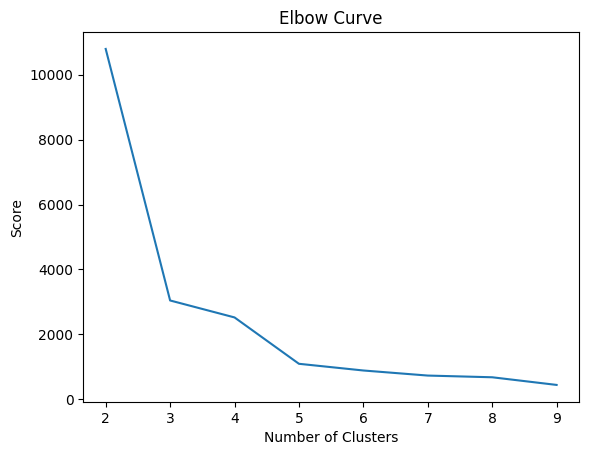

In [ ]:
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
# membangun Model K-Means Clustering

KMeans_algo=KMeans(featuresCol='standardized', k=3)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [ ]:
# Membuat prediksi

preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+--------+---------+------------------+----------+------------------------------------+------------------------------------------------------------+----------+
|recency |frequency|monetary_value    |CustomerID|features                            |standardized                                                |prediction|
+--------+---------+------------------+----------+------------------------------------+------------------------------------------------------------+----------+
|45885060|11       |184.29000000000002|12493.0   |[4.588506E7,11.0,184.29000000000002]|[5.254522415034828,0.0381111156188601,0.041256890228470004] |0         |
|43564740|11       |184.29000000000002|12493.0   |[4.356474E7,11.0,184.29000000000002]|[4.988811234749707,0.0381111156188601,0.041256890228470004] |0         |
|35362500|11       |264.7             |13973.0   |[3.53625E7,11.0,264.7]              |[4.049532656199406,0.0381111156188601,0.059258228029062936] |0         |
|44422080|33       |124.14999999999999|1

6. Analisa Cluster

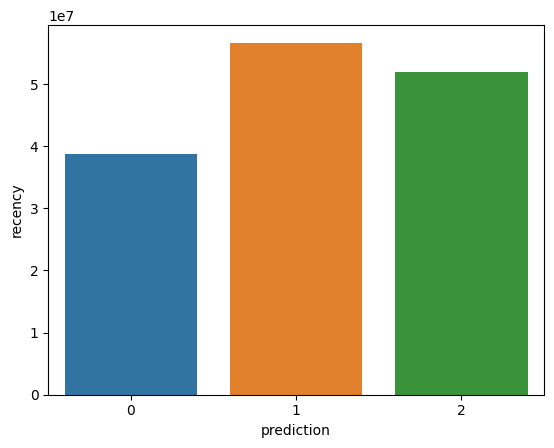

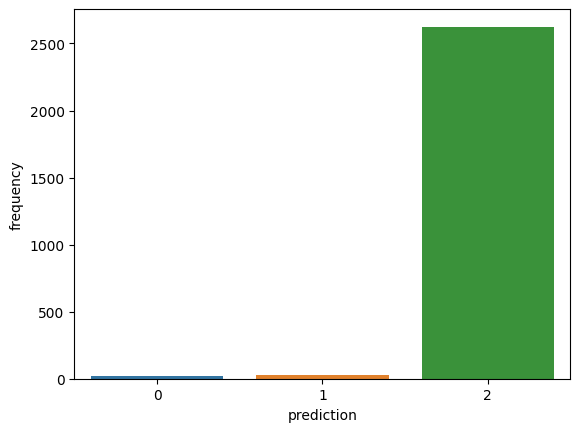

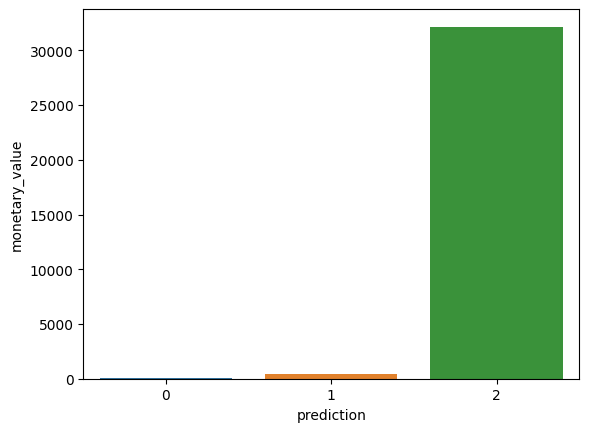

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()